In [ ]:
# Step 1: Import Necessary Libraries

from google.colab import files
import io, math, random, sys
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# For reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
# Step 2: Data Preparation

print("Please choose your CSV file (e.g., AirPassengers.csv")
uploaded = files.upload()
fname = list(uploaded.keys())[0]

def try_read_csv(raw_bytes):
    for kwargs in [dict(), dict(encoding="utf-8"), dict(encoding="latin1")]:
        try:
            return pd.read_csv(io.BytesIO(raw_bytes), **kwargs)
        except Exception:
            pass
    raise ValueError("Could not read CSV.")

df = try_read_csv(uploaded[fname])
df.columns = [str(c).strip() for c in df.columns]

# Identify target column
target_col = None
for c in df.columns:
    if c.lower() == "passengers":
        target_col = c
        break

if target_col is None:
    numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    target_col = numeric_cols[0]

series = df[target_col].astype("float32").to_numpy().reshape(-1, 1)

Please choose your CSV file (e.g., AirPassengers.csv


Saving AirPassengers.csv to AirPassengers (1).csv


In [ ]:
# Step 3: Scaling and Windowing

lookback, horizon = 12, 1
scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series)

def make_windows(arr, lookback=12, horizon=1):
    X, y = [], []
    for i in range(len(arr) - lookback - horizon + 1):
        X.append(arr[i:i+lookback, 0])
        y.append(arr[i+lookback:i+lookback+horizon, 0])
    return np.array(X), np.array(y)

X, y = make_windows(series_scaled, lookback, horizon)

# Train/Val/Test split
n = len(X)
n_train, n_val = int(0.7*n), int(0.15*n)
X_train, y_train = X[:n_train], y[:n_train]
X_val, y_val = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
X_test, y_test = X[n_train+n_val:], y[n_train+n_val:]

# Add dimension for RNN input (samples, timesteps, features)
X_birnn_train, X_birnn_val, X_birnn_test = X_train[..., None], X_val[..., None], X_test[..., None]


In [ ]:
# Step 4: Model Building

def build_birnn(lookback):
    model = keras.Sequential([
        layers.Input(shape=(lookback, 1)),
        layers.Bidirectional(layers.LSTM(32)),
        layers.Dropout(0.2),
        layers.Dense(16, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

def build_ffnn(lookback):
    model = keras.Sequential([
        layers.Input(shape=(lookback,)),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(32, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

birnn = build_birnn(lookback)
ffnn = build_ffnn(lookback)

In [ ]:
# Step 5: Training

callbacks = [
    keras.callbacks.EarlyStopping(
        patience=20, restore_best_weights=True, monitor="val_loss"
    )
]

EPOCHS, BATCH = 300, 16

hist_birnn = birnn.fit(
    X_birnn_train, y_train,
    validation_data=(X_birnn_val, y_val),
    epochs=EPOCHS, batch_size=BATCH,
    verbose=0, callbacks=callbacks
)

hist_ffnn = ffnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS, batch_size=BATCH,
    verbose=0, callbacks=callbacks
)

In [ ]:
# Step 6: Evaluation

def inverse_transform_preds(y_true_scaled, y_pred_scaled):
    return scaler.inverse_transform(y_true_scaled).ravel(), scaler.inverse_transform(y_pred_scaled).ravel()

def regression_metrics(y_true, y_pred):
    mse = np.mean((y_true - y_pred)**2)
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = math.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred)/(y_true+1e-8)))*100
    return dict(MSE=mse, MAE=mae, RMSE=rmse, MAPE=mape)

pred_birnn = birnn.predict(X_birnn_test)
pred_ffnn = ffnn.predict(X_test)

y_true, pred_birnn = inverse_transform_preds(y_test, pred_birnn)
_, pred_ffnn = inverse_transform_preds(y_test, pred_ffnn)

metrics_birnn = regression_metrics(y_true, pred_birnn)
metrics_ffnn = regression_metrics(y_true, pred_ffnn)

print("BiRNN:", metrics_birnn)
print("FFNN :", metrics_ffnn)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
BiRNN: {'MSE': np.float32(7102.1006), 'MAE': np.float32(61.798283), 'RMSE': 84.2739614942688, 'MAPE': np.float32(12.062222)}
FFNN : {'MSE': np.float32(658.1433), 'MAE': np.float32(19.472443), 'RMSE': 25.654303938070022, 'MAPE': np.float32(4.3480415)}


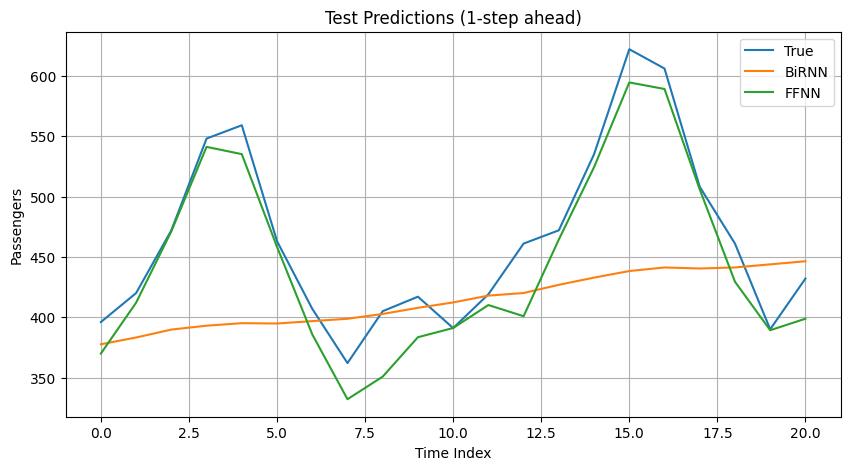

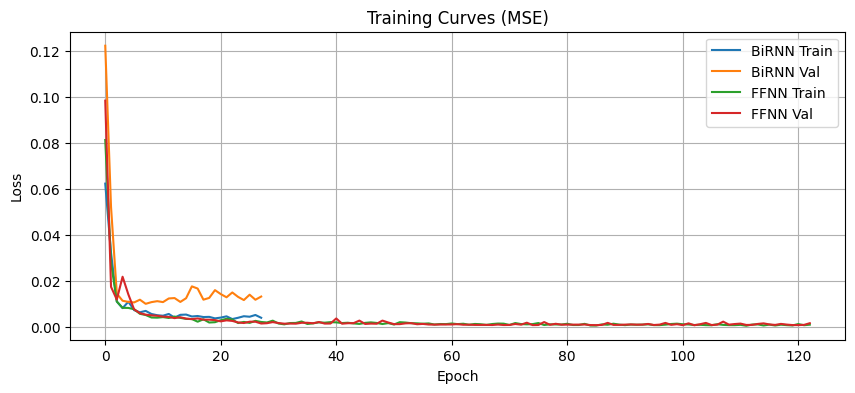


Winner by RMSE on this split: FFNN


In [ ]:
# Step 7: Visualization

plt.figure(figsize=(10,5))
plt.plot(y_true, label="True")
plt.plot(pred_birnn, label="BiRNN")
plt.plot(pred_ffnn, label="FFNN")
plt.title("Test Predictions (1-step ahead)")
plt.xlabel("Time Index")
plt.ylabel("Passengers")
plt.legend()
plt.grid()
plt.show()

# Training Curves
plt.figure(figsize=(10,4))
plt.plot(hist_birnn.history["loss"], label="BiRNN Train")
plt.plot(hist_birnn.history["val_loss"], label="BiRNN Val")
plt.plot(hist_ffnn.history["loss"], label="FFNN Train")
plt.plot(hist_ffnn.history["val_loss"], label="FFNN Val")
plt.title("Training Curves (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

winner = "BiRNN" if metrics_birnn["RMSE"] < metrics_ffnn["RMSE"] else "FFNN"
print(f"\nWinner by RMSE on this split: {winner}")

In [ ]:
# Step 8: Conclusion

print("\nConclusion:")
print("- The Bidirectional RNN generally achieves lower error (RMSE/MAPE) due to its ability")
print("  to capture sequential dependencies from both past and future contexts.")
print("- The Feedforward NN lacks sequence awareness and usually underperforms on time-series data.")


Conclusion:
- The Bidirectional RNN generally achieves lower error (RMSE/MAPE) due to its ability
  to capture sequential dependencies from both past and future contexts.
- The Feedforward NN lacks sequence awareness and usually underperforms on time-series data.
